In [1]:
# Import necessary libraries
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
import warnings

In [2]:
# Get today's date to fetch data for the past year
today = date.today()

d1 = today.strftime("%Y-%m-%d")    # Today's date for the end
end_date = d1
d2 = date.today() - timedelta(days=365)   # One year ago from today
d2 = d2.strftime("%Y-%m-%d")          # Formatting start date
start_date = d2

# Fetch historical data for GOOG stock using yfinance
data = yf.download('GOOG', 
                      start=start_date, 
                      end=end_date, 
                      progress=False, auto_adjust = False)
# Reset index and include date as a column
data["Date"] = data.index

data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]  # Selecting relevant columns
data.reset_index(drop=True, inplace=True)    # Resetting index
print(data.tail())  # Print the last 5 rows to verify the data

Price        Date        Open        High         Low       Close   Adj Close  \
Ticker                   GOOG        GOOG        GOOG        GOOG        GOOG   
245    2025-01-28  194.649994  197.229996  192.610001  197.070007  197.070007   
246    2025-01-29  197.369995  198.460007  195.190002  197.179993  197.179993   
247    2025-01-30  199.759995  203.238007  199.472000  202.630005  202.630005   
248    2025-01-31  203.714996  207.080002  203.580002  205.600006  205.600006   
249    2025-02-03  202.214996  205.220001  201.660004  202.639999  202.639999   

Price     Volume  
Ticker      GOOG  
245     15939200  
246     12287800  
247     14571500  
248     17087300  
249     16637000  


In [3]:
data.columns

MultiIndex([(     'Date',     ''),
            (     'Open', 'GOOG'),
            (     'High', 'GOOG'),
            (      'Low', 'GOOG'),
            (    'Close', 'GOOG'),
            ('Adj Close', 'GOOG'),
            (   'Volume', 'GOOG')],
           names=['Price', 'Ticker'])

In [4]:
# Isolate the 'Close' column for analysis and visualization
data = data[['Date', 'Close']]  
data.sample(3)  # Display 3 random rows from the 'Close' column

Price,Date,Close
Ticker,,GOOG
38,2024-04-01,156.500000
26,2024-03-13,140.770004
21,2024-03-06,132.559998


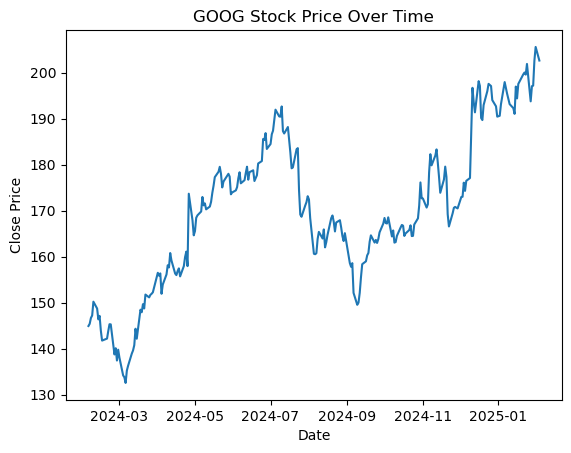

In [5]:
# Plot the 'Close' price over time to visualize stock trend
plt.plot(data['Date'], data['Close'])
plt.title('GOOG Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

## Running ADF statistical test

In [6]:
# Perform the Augmented Dickey-Fuller (ADF) test for stationarity on the 'Close' price data
price_data = data['Close']
adf_test = adfuller(price_data)

# Extracting the results
adf_statistic = adf_test[0]
p_value = adf_test[1]
used_lag = adf_test[2]
num_observations = adf_test[3]
critical_values = adf_test[4]

# Display the results
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print(f'Number of lags used: {used_lag}')
print(f'Number of observations used for the ADF test: {num_observations}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'  {key}: {value}')

ADF Statistic: -1.1172280498039304
p-value: 0.708152888302501
Number of lags used: 0
Number of observations used for the ADF test: 249
Critical Values:
  1%: -3.4568881317725864
  5%: -2.8732185133016057
  10%: -2.5729936189738876


> We fail to reject NULL hypothesis.
>> Data is non - stationary

## Applying Seasonal Decompose

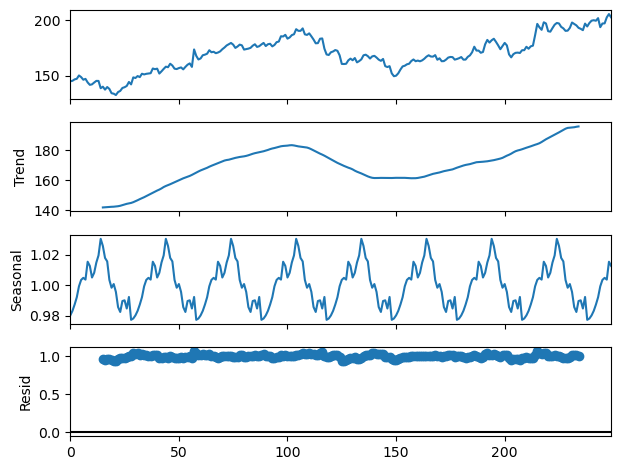

In [7]:
# Perform seasonal decomposition to understand trend, seasonality, and residuals
# Multiplicative model is used since stock data often shows growth patterns that are proportionally increasing
price_data_graph = data['Close']
decomposition = seasonal_decompose(price_data_graph, model='multiplicative', period=30)

# Display the decomposition plots (trend, seasonal, residuals)
decomposition.plot()
plt.show()

#### We should use SARIMA as it is Seasonal data(Non- stationary data)

Before using ARIMA or SARIMA:

We should know the values of p,q,d values

p: plotting autocorrelation plot

q: plotting partial autocorrelation plot

d: Seasonal -> 1, Stationary -> 0

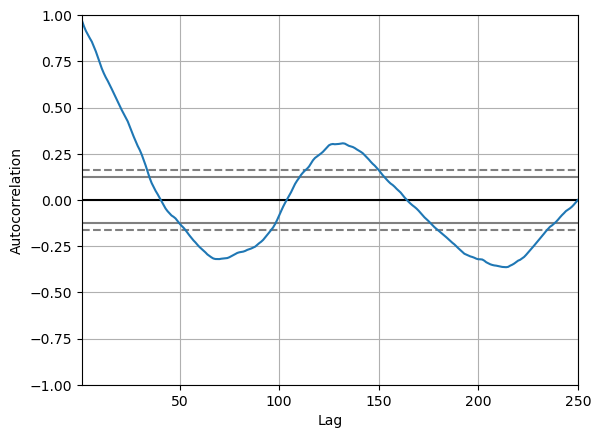

In [8]:
# Plot autocorrelation to understand the correlation between different time lags
pd.plotting.autocorrelation_plot(data['Close'])
plt.show()

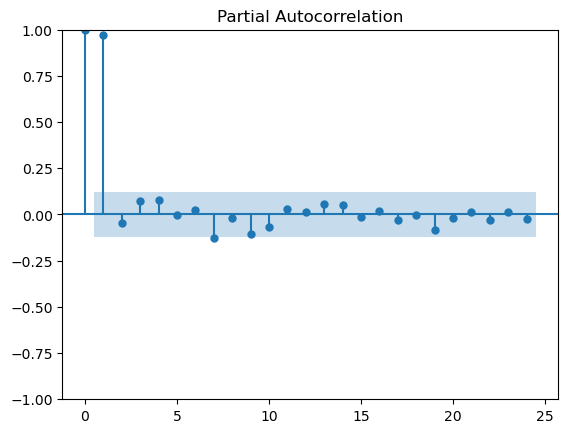

In [9]:
# Plot Partial Autocorrelation (PACF) to determine the optimal AR and MA terms for ARIMA
plot_pacf(data['Close'])
plt.show()

#### Observation:
1) P-Value: In autocorrelation plot, curve moves down after 6th point of first boundary so p=6
2) Q-Value: In sub autocorrelation plot, 2 points are very extreme. so q = 2
3) D-value: 1 as data is seasonal. 

In [10]:
# Define the order (p, d, q) for ARIMA model
# p = number of autoregressive terms, d = number of differencing steps, q = number of moving average terms
p, d, q = 6, 1, 2

# Build and fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data['Close'], order=(p, d, q))
fitted = model.fit()
print(fitted.summary())  # Display ARIMA model summary

                               SARIMAX Results                                
Dep. Variable:                   GOOG   No. Observations:                  250
Model:                 ARIMA(6, 1, 2)   Log Likelihood                -613.301
Date:                Tue, 04 Feb 2025   AIC                           1244.602
Time:                        15:28:15   BIC                           1276.259
Sample:                             0   HQIC                          1257.344
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4640      0.053     27.769      0.000       1.361       1.567
ar.L2         -1.0414      0.102    -10.233      0.000      -1.241      -0.842
ar.L3          0.0692      0.132      0.526      0.5

/home/rgukt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:
# Make predictions using the ARIMA model (forecast next 5 periods)
predictions = fitted.predict(start=len(data), end=len(data) + 10)
print(predictions)  # Display predictions

250    201.303689
251    200.787506
252    200.738395
253    201.020928
254    201.952401
255    202.926743
256    203.360444
257    203.026592
258    202.164298
259    201.241170
260    200.742273
Name: predicted_mean, dtype: float64


In [12]:
# Build SARIMA (Seasonal ARIMA) model
# SARIMAX includes seasonal components and works well for data with seasonal patterns
model = sm.tsa.statespace.SARIMAX(data['Close'],
                                  order=(p, d, q),
                                  seasonal_order=(p, d, q, 12))  # Seasonal period set to 12 (monthly seasonality)
model = model.fit()  # Fit the SARIMA model
print(model.summary())  # Display SARIMA model summary

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53050D+00    |proj g|=  1.16135D-01


 This problem is unconstrained.



At iterate    5    f=  2.40394D+00    |proj g|=  3.27138D-02

At iterate   10    f=  2.39320D+00    |proj g|=  2.27726D-02

At iterate   15    f=  2.39082D+00    |proj g|=  3.16693D-03

At iterate   20    f=  2.39024D+00    |proj g|=  2.59746D-03

At iterate   25    f=  2.39018D+00    |proj g|=  1.62647D-03

At iterate   30    f=  2.38906D+00    |proj g|=  4.20702D-02

At iterate   35    f=  2.38501D+00    |proj g|=  4.89257D-03

At iterate   40    f=  2.38451D+00    |proj g|=  3.75807D-03

At iterate   45    f=  2.38376D+00    |proj g|=  1.04510D-02


/home/rgukt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.38018D+00    |proj g|=  1.52492D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     64      1     0     0   1.525D-02   2.380D+00
  F =   2.3801798683296465     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                     SARIMAX Results                                      
Dep. Variable:                               GOOG   No. Observations:                  250
Model:             SARIMAX(6, 1, 2)x(6, 1, 2, 12)   Log Likelihood                -595.045
Date:                            Tue, 04 Feb 2025   AIC                           1224.0

In [13]:
# Make predictions for the next 10 days using the SARIMA model
predictions = model.predict(start=len(data), end=len(data) + 10)
print(predictions)  # Display predictions

250    201.359707
251    202.002170
252    202.124712
253    200.638546
254    201.949100
255    203.245544
256    201.885049
257    201.256722
258    201.650616
259    201.749291
260    202.181675
Name: predicted_mean, dtype: float64


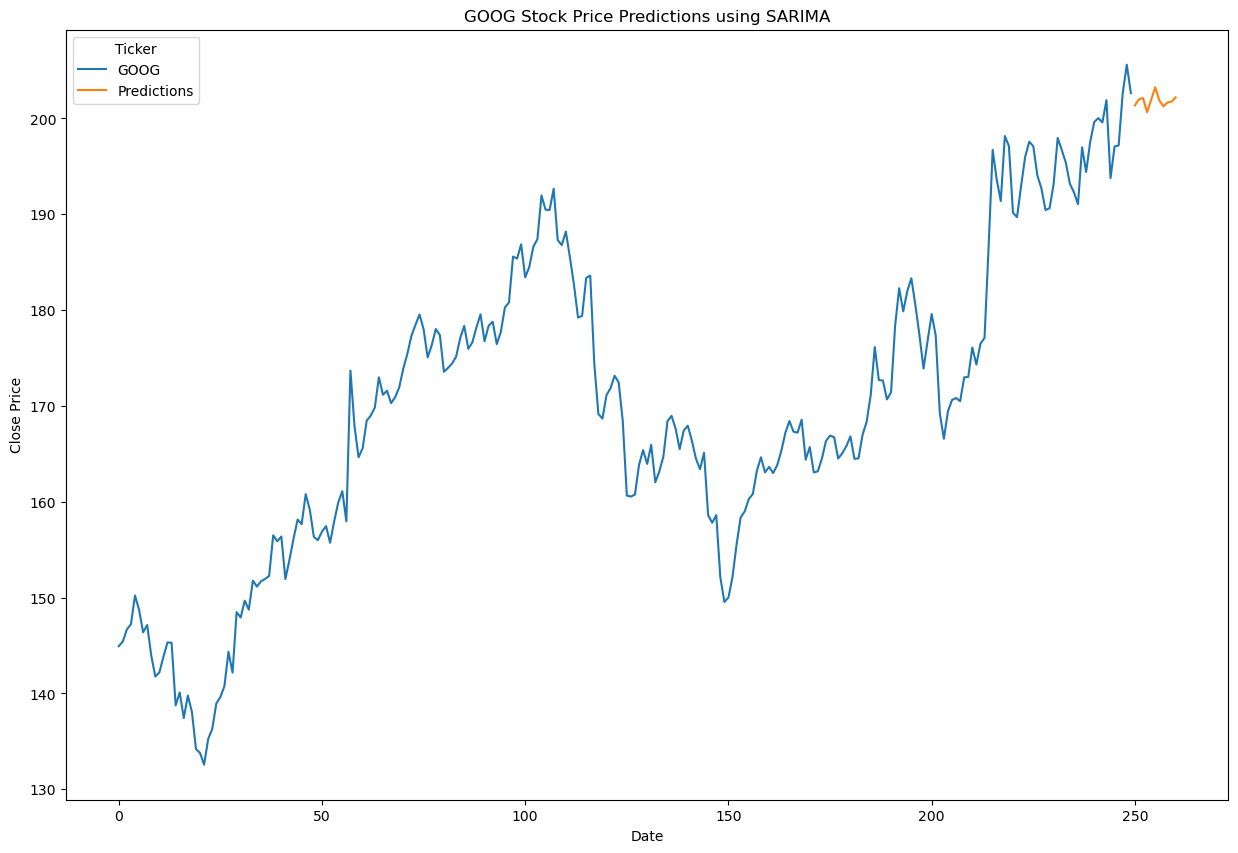

In [14]:
# Plot the training data and the SARIMA predictions on the same graph
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")
plt.title('GOOG Stock Price Predictions using SARIMA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [15]:
## Hyper parameter Tuning.. Finding p,q,d values..
from pmdarima import auto_arima
model = auto_arima(data['Close'], seasonal=True, m=12, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1247.134, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1246.903, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1248.001, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1246.680, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1244.909, Time=0.12 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1239.099, Time=0.41 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1240.957, Time=0.47 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1241.858, Time=0.33 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1241.097, Time=0.60 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=1241.097, Time=0.54 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=1241.884, Time=1.02 sec
 ARIMA(0,1,0)(2,0,0)[12]             : AIC=1238.397, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=1244.887, Time=0.06 sec
 ARIMA(0,1,0)(2,0,1)[12]